In [1]:
#meta 1/26/2021 Data Images 
#Explore one image: open, view and manipulate images with PIL
#tried aug_transforms on one image, no success with fast.ai v2
#refer to v1 https://github.com/anyaconda/my-fastai-project/blob/master/kaggle_resources/code_others/my-data-augmentation-in-fastai.ipynb


#reference
#fastai==2.1.8 with !pip freeze
#https://nbviewer.jupyter.org


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import os
import time #to track performance time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#modeling
from fastai.vision.all import *
#from fastai.vision import *


# Input data files are available in the read-only "../input/" directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 0. Load Data
and basic info

In [3]:
path = Path('../input/cassava-leaf-disease-classification')
path.ls()

(#7) [Path('../input/cassava-leaf-disease-classification/train_tfrecords'),Path('../input/cassava-leaf-disease-classification/sample_submission.csv'),Path('../input/cassava-leaf-disease-classification/test_tfrecords'),Path('../input/cassava-leaf-disease-classification/label_num_to_disease_map.json'),Path('../input/cassava-leaf-disease-classification/train_images'),Path('../input/cassava-leaf-disease-classification/train.csv'),Path('../input/cassava-leaf-disease-classification/test_images')]

In [4]:
(path/'train_images').ls(), (path/'test_images').ls()

((#21397) [Path('../input/cassava-leaf-disease-classification/train_images/1235188286.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/1215607589.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/478554372.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/2763304605.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/2826122413.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/111117998.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/231268038.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/4201965605.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/3224710052.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/1290729293.jpg')...],
 (#1) [Path('../input/cassava-leaf-disease-classification/test_images/2216849948.jpg')])

In [5]:
with open((path/'label_num_to_disease_map.json')) as json_file:
    target_map = json.load(json_file)
    
print(target_map)

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


## 1. One Image - Shallow Dive

Using `Image` class from the Python Imaging Library `PIL` most widely used for opening, viewing and manipulatig images. Jupyter displays PIL images automatically. 

https://docs.fast.ai/vision.core.html

In [6]:
#define variables and functions

#view an image
img_example = '100042118.jpg' 

#load train images
train_img = get_image_files(path/'train_images')
img_example2 = train_img[0] # '1235188286.jpg'

#only works with PIL Image
def get_ex(): return Image.open(path/'train_images'/img_example)

def plots_f(rows, cols, width, height, **kwargs):
    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

 Image.size `w*h`  
 Image.shape `h*w`, same order as numpy array and pytorch tensor

../input/cassava-leaf-disease-classification/train_images/100042118.jpg
RGB 3 (800, 600) (600, 800)


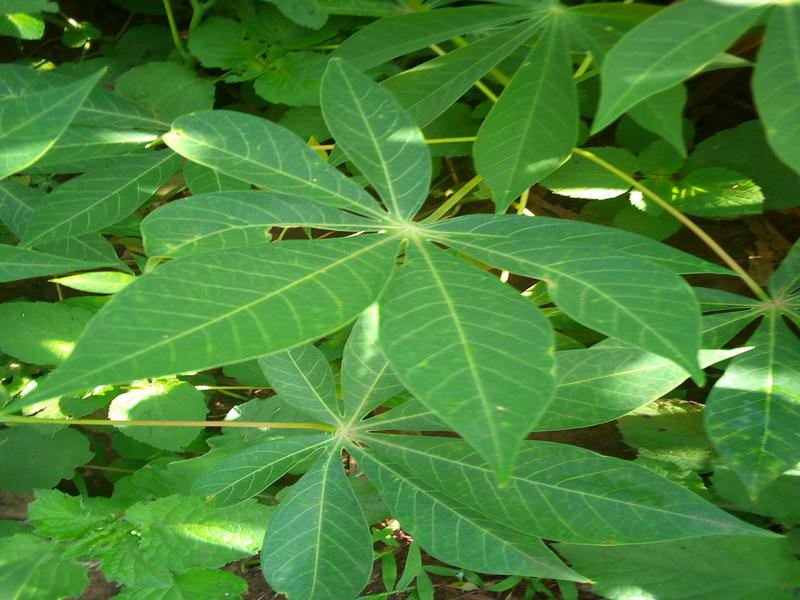

In [7]:
print(path/'train_images'/img_example)
img = Image.open(path/'train_images'/img_example) #PIL.JpegImagePlugin.JpegImageFile
print(img.mode, img.layers, img.size, img.shape) #size w*h, shape h*w
img

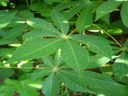

In [8]:
img.to_thumb(128)

../input/cassava-leaf-disease-classification/train_images/1235188286.jpg
RGB 3 (800, 600) (600, 800)


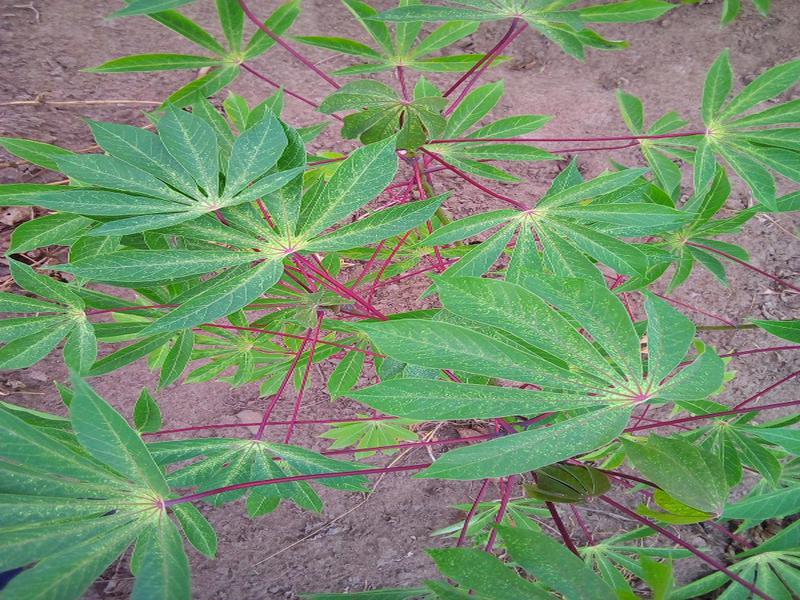

In [9]:
print(img_example2)
img2 = Image.open(img_example2)
print(img2.mode, img2.layers, img2.size, img2.shape)
img2

To a computer, everything is represented by numbers. To see the numbers that make up the image, convert it to a `Numpy array` or `PyTorch` tensor.  
`h*w*c` dims order

In [10]:
print (array(img).shape) # h*w*c
#numpy indexes from top to bottom, from L to R -> bottom right corner of the image
array(img)[595:600, 798:800, :] #5 rows of 2 columns and all 3 channels

(600, 800, 3)


array([[[45, 91, 42],
        [51, 95, 46]],

       [[46, 93, 39],
        [49, 96, 44]],

       [[46, 93, 38],
        [48, 95, 41]],

       [[45, 92, 37],
        [46, 93, 38]],

       [[44, 94, 35],
        [44, 92, 34]]], dtype=uint8)

In [11]:
print(tensor(img).shape)
tensor(img)[595:600, 798:800, :]

torch.Size([600, 800, 3])


tensor([[[45, 91, 42],
         [51, 95, 46]],

        [[46, 93, 39],
         [49, 96, 44]],

        [[46, 93, 38],
         [48, 95, 41]],

        [[45, 92, 37],
         [46, 93, 38]],

        [[44, 94, 35],
         [44, 92, 34]]], dtype=torch.uint8)

Transform image to byte tensor in `c*h*w` dim order.

In [12]:
img_tensor = image2tensor(img) #cxhxd
print(img_tensor.shape)
img_tensor

torch.Size([3, 600, 800])


tensor([[[ 69,  68,  66,  ..., 185, 185, 184],
         [ 66,  66,  64,  ..., 169, 168, 168],
         [ 63,  61,  60,  ..., 144, 144, 143],
         ...,
         [ 97,  97,  98,  ...,  43,  46,  48],
         [ 98,  98,  99,  ...,  44,  45,  46],
         [101, 102, 102,  ...,  44,  44,  44]],

        [[131, 130, 128,  ..., 235, 235, 235],
         [132, 129, 127,  ..., 218, 219, 219],
         [129, 127, 126,  ..., 197, 196, 197],
         ...,
         [167, 167, 169,  ...,  93,  93,  95],
         [168, 168, 170,  ...,  94,  92,  93],
         [171, 172, 172,  ...,  96,  94,  92]],

        [[ 64,  63,  61,  ..., 114, 114, 114],
         [ 61,  59,  57,  ..., 100, 100, 101],
         [ 55,  53,  52,  ...,  83,  85,  85],
         ...,
         [ 97,  95,  93,  ...,  34,  38,  41],
         [ 98,  96,  94,  ...,  33,  37,  38],
         [101, 100,  99,  ...,  34,  35,  34]]], dtype=torch.uint8)

### Basic Image operations
- Properties
- Reshape and Resize

In [13]:
type(img),img.mode, str(img)

(PIL.JpegImagePlugin.JpegImageFile,
 'RGB',
 '<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=800x600 at 0x7FC02D48E910>')

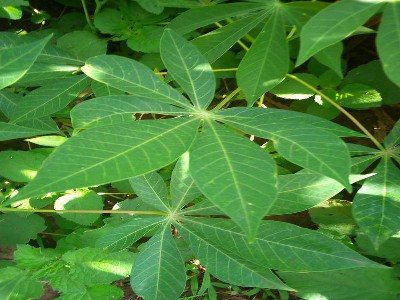

In [14]:
img_reshaped = img.reshape(300, 400)
img_reshaped

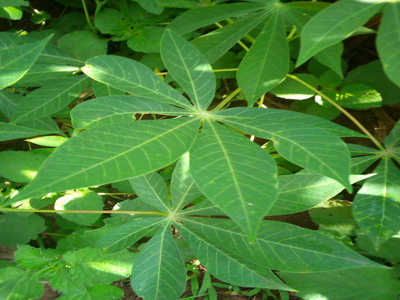

In [15]:
img_resized = img.resize((400,300))
img_resized

In [16]:
#no effect on img
#img
img.n_px, img_reshaped.n_px, img_resized.n_px

(480000, 120000, 120000)

### Basic Transforms
https://docs.fast.ai/vision.core.html#Basic-Transforms

In [17]:
tfm = ToTensor()
print(tfm)
print('\n', type(img)) # same as __class__
print('\n', type(tfm(img))) # same as __class__

ToTensor:
encodes: (PILMask,object) -> encodes
(PILBase,object) -> encodes
decodes: 

 <class 'PIL.JpegImagePlugin.JpegImageFile'>

 <class 'PIL.JpegImagePlugin.JpegImageFile'>


In [18]:
#if True => no assertion error
test_eq(tfm(img).shape, (600,800))

### Aug Transforms
https://docs.fast.ai/vision.augment.html#CropPad

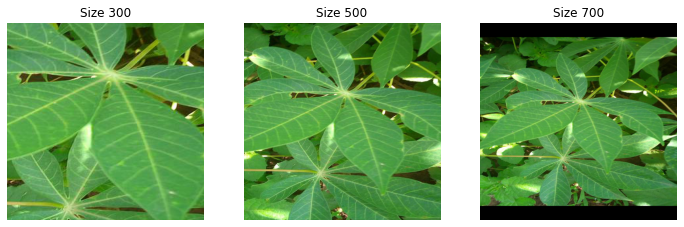

In [19]:
_,axs = plt.subplots(1,3,figsize=(12,4))
for ax,sz in zip(axs.flatten(), [300, 500, 700]):
    show_image(img.crop_pad(sz), ctx=ax, title=f'Size {sz}');

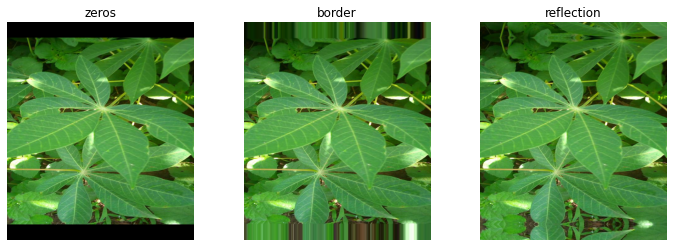

In [20]:
_,axs = plt.subplots(1,3,figsize=(12,4))
for ax,mode in zip(axs.flatten(), [PadMode.Zeros, PadMode.Border, PadMode.Reflection]):
    show_image(img.crop_pad((600,700), pad_mode=mode), ctx=ax, title=mode);

No luck with zoom, flip, etc.  Move on to batch aug_transforms.